In [ ]:
from optimization import *
import sys
sys.path.append("../python")
import parseCouplings

In [2]:
# Todo: replace this function with actual file reading
def readHamiltonian_params(file, idx, N):
    Jijalphabeta = np.random.rand(3, 3, N, N)
    h = np.random.rand(3, N)

    # Delete 90% of the elements randomly in Jijalphabeta
    mask_J = np.random.rand(3, 3, N, N) < 0.1
    Jijalphabeta = Jijalphabeta * mask_J

    # Delete 90% of the elements randomly in h
    mask_h = np.random.rand(3, N) < 0.1
    h = h * mask_h

    return Jijalphabeta, h


def generate_tfim_params(N, J=1.0, h=1.0):
    """
    Generates Jij and h arrays for the transverse field Ising model (TFIM):
    H = -J sum_{<i,j>} sigma^z_i sigma^z_j - h sum_i sigma^x_i

    Args:
        N (int): Number of spins (1D chain with periodic boundary).
        J (float): Coupling strength.
        h (float): Transverse field strength.

    Returns:
        Jij (np.ndarray): shape (3, 3, N, N), only Jij[2,2,i,j] nonzero for nearest neighbors.
        h (np.ndarray): shape (3, N), only h[0,i] nonzero (x direction).
    """
    Jij = np.zeros((3, 3, N, N))
    for i in range(N):
        j = (i + 1) % N  # periodic boundary
        Jij[2, 2, i, j] = -J
        Jij[2, 2, j, i] = -J  # symmetric

    h_arr = np.zeros((3, N))
    h_arr[0, :] = -h  # transverse field in x direction

    return Jij, h_arr

In [43]:
Jij, h = readHamiltonian_params("hamiltonian_params.txt", 0, 5)
# Jij, h = generate_tfim_params(10, J=-1.0, h=1.0)
H = construct_hamiltonian(Jij, h)
exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)
print("Exact ground state energy:", exact_ground_energy)

Exact ground state energy: [-1.98881176]


In [60]:
def construct_hamiltonian_bonds(Jijalphabeta, h, bonds):
    N = h.shape[0]
    hilbert = nk.hilbert.Spin(s=0.5, N=N)
    pauli = [sigmax, sigmay, sigmaz]

    # Interaction terms
    interaction_terms = [
        Jijalphabeta[bond, alpha, beta] * pauli[alpha](hilbert,i) * pauli[beta](hilbert,j)
        for (bond,(i,j)) in enumerate(bonds)
        for alpha in range(3)
        for beta in range(3)
        if np.abs(Jijalphabeta[bond, alpha, beta]) > 1e-12
    ]

    # Local field terms
    field_terms = [
        h[i,alpha] * pauli[alpha](hilbert, i)
        for i in range(N)
        for alpha in range(3)
        if np.abs(h[i,alpha]) > 1e-12
    ]

    ha = sum(interaction_terms, nk.operator.LocalOperator(hilbert)) + sum(field_terms, nk.operator.LocalOperator(hilbert))
    # ha = 0.5*(ha + ha.H)  # Ensure Hermiticity
    return ha

In [46]:
g.edges()[1]

(12, 13)

In [48]:
h[0].shape

(16, 3)

In [61]:
# Jij, h = readHamiltonian_params("hamiltonian_params.txt", 0, 5)
os.chdir("../python")
g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)
Jij,h = parseCouplings.parseCouplings()
H = construct_hamiltonian_bonds(Jij[10], h[10],  g.edges())

exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)
print("Exact ground state energy:", exact_ground_energy)

Exact ground state energy: [-70.88827839]


In [64]:
Jij_hash = hash(Jij.tobytes())
h_hash = hash(h.tobytes())

params = generate_params(
    alpha=10,
    seed=1234,
    learning_rate=3e-3,
    n_iter=100,
    show_progress=True,
    out="data/rbm_optimization_test",
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

out = optimize_rbm(H, params)


100%|██████████| 100/100 [01:12<00:00,  1.37it/s, Energy=-3.534e+01-2.220e-16j ± 0.000e+00 [σ²=1.933e+02]]


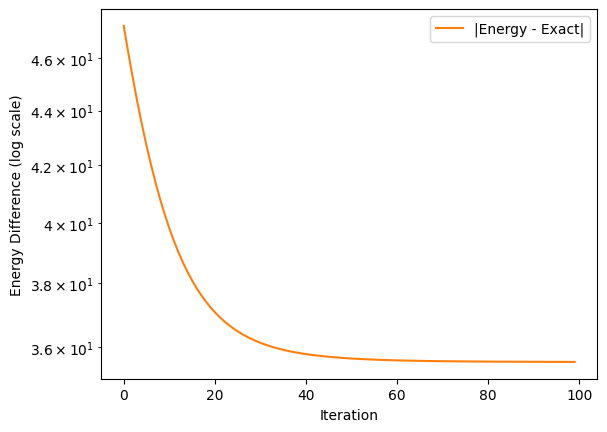

In [66]:
# import the data from log file
import matplotlib.pyplot as plt
data_rbm = json.load(open(params["out"]+".log"))

iters_Jastrow = data_rbm["Energy"]["iters"]
# energy_Jastrow = np.real(data_rbm["Energy"]["Mean"])
energy_Jastrow = data_rbm["Energy"]["Mean"]["real"]
energy_diff = np.abs(energy_Jastrow - exact_ground_energy[0])

fig, ax2 = plt.subplots()
ax2.plot(iters_Jastrow, energy_diff, color="C1", label="|Energy - Exact|")
ax2.set_yscale("log")
ax2.set_ylabel("Energy Difference (log scale)")
ax2.set_xlabel("Iteration")
ax2.legend()
plt.show()


In [6]:
write_output(H, out, params)

In [67]:
Jij,h = parseCouplings.parseCouplings()
for i in range(300):
    H = construct_hamiltonian_bonds(Jij[i], h[i],  g.edges())

    exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)
    print("Exact ground state energy:", exact_ground_energy)
    exact_ground_energy, exact_ground_state = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)
    print(f"Hamiltonian {i+1}: Exact ground state energy: {exact_ground_energy[0]}")
    
    Jij_hash = hash(Jij.tobytes())
    h_hash = hash(h.tobytes())
    params = generate_params(
        alpha=1,
        seed=1234,
        learning_rate=3e-2,
        n_iter=1000,
        show_progress=True,
        out=f"data_rand/rbm_optimization_{i}",
    )
    
    out = optimize_rbm(H, params)
    
    write_output(H, out, params)

Exact ground state energy: [-67.59341437]
Hamiltonian 1: Exact ground state energy: -67.59341437347759


100%|██████████| 1000/1000 [02:22<00:00,  7.00it/s, Energy=-2.344e+01+3.608e-16j ± 0.000e+00 [σ²=3.075e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-64.33123667]
Hamiltonian 2: Exact ground state energy: -64.33123666702


100%|██████████| 1000/1000 [02:14<00:00,  7.46it/s, Energy=-5.133e+01-1.110e-16j ± 0.000e+00 [σ²=8.259e+01]]


Exact ground state energy: [-61.29645976]
Hamiltonian 3: Exact ground state energy: -61.29645976096796


100%|██████████| 1000/1000 [01:34<00:00, 10.54it/s, Energy=-2.466e+01+2.776e-16j ± 0.000e+00 [σ²=2.045e+02]]


Exact ground state energy: [-69.90451915]
Hamiltonian 4: Exact ground state energy: -69.90451915204429


100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s, Energy=-5.099e+01-2.220e-16j ± 0.000e+00 [σ²=1.781e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-64.56263725]
Hamiltonian 5: Exact ground state energy: -64.56263724850196


100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s, Energy=-5.774e+01-5.441e-16j ± 0.000e+00 [σ²=1.014e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-52.96306985]
Hamiltonian 6: Exact ground state energy: -52.963069846329546


100%|██████████| 1000/1000 [02:29<00:00,  6.69it/s, Energy=-2.467e+01-1.249e-16j ± 0.000e+00 [σ²=1.566e+02]]


Exact ground state energy: [-76.67122683]
Hamiltonian 7: Exact ground state energy: -76.67122682785084


100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s, Energy=-4.962e+01+3.331e-16j ± 0.000e+00 [σ²=4.283e+02]]


Exact ground state energy: [-106.1817312]
Hamiltonian 8: Exact ground state energy: -106.1817311988611


100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s, Energy=-4.368e+01-6.661e-16j ± 0.000e+00 [σ²=4.233e+02]]


Exact ground state energy: [-64.12636926]
Hamiltonian 9: Exact ground state energy: -64.12636925681241


100%|██████████| 1000/1000 [00:22<00:00, 45.24it/s, Energy=-2.341e+01-1.379e-16j ± 0.000e+00 [σ²=2.616e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-72.92181271]
Hamiltonian 10: Exact ground state energy: -72.92181271143698


100%|██████████| 1000/1000 [02:20<00:00,  7.11it/s, Energy=-5.773e+01+0.000e+00j ± 0.000e+00 [σ²=2.053e+02]]


Exact ground state energy: [-70.88827839]
Hamiltonian 11: Exact ground state energy: -70.88827839195149


100%|██████████| 1000/1000 [02:22<00:00,  7.01it/s, Energy=-3.546e+01-1.110e-16j ± 0.000e+00 [σ²=1.938e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-74.73594338]
Hamiltonian 12: Exact ground state energy: -74.73594338271873


100%|██████████| 1000/1000 [02:35<00:00,  6.45it/s, Energy=-2.506e+01-1.554e-15j ± 0.000e+00 [σ²=4.428e+02]]


Exact ground state energy: [-69.51353496]
Hamiltonian 13: Exact ground state energy: -69.51353495878138


100%|██████████| 1000/1000 [01:21<00:00, 12.25it/s, Energy=-5.216e+01+7.910e-16j ± 0.000e+00 [σ²=2.327e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-49.3777212]
Hamiltonian 14: Exact ground state energy: -49.377721198444725


100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s, Energy=-3.287e+01-1.249e-16j ± 0.000e+00 [σ²=9.603e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-61.39464415]
Hamiltonian 15: Exact ground state energy: -61.3946441518944


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s, Energy=-2.021e+01-1.665e-16j ± 0.000e+00 [σ²=2.931e+02]]


Exact ground state energy: [-84.00756352]
Hamiltonian 16: Exact ground state energy: -84.00756351712283


100%|██████████| 1000/1000 [00:52<00:00, 19.17it/s, Energy=-7.610e+01-1.665e-16j ± 0.000e+00 [σ²=1.680e+02]]


Exact ground state energy: [-72.45527383]
Hamiltonian 17: Exact ground state energy: -72.4552738346861


100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s, Energy=-4.917e+01-8.882e-16j ± 0.000e+00 [σ²=2.595e+02]]


Exact ground state energy: [-64.97153521]
Hamiltonian 18: Exact ground state energy: -64.9715352122894


100%|██████████| 1000/1000 [02:07<00:00,  7.81it/s, Energy=-5.527e+01+2.151e-16j ± 0.000e+00 [σ²=1.367e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-59.06400785]
Hamiltonian 19: Exact ground state energy: -59.064007845301475


100%|██████████| 1000/1000 [02:21<00:00,  7.06it/s, Energy=-4.406e+01-2.220e-16j ± 0.000e+00 [σ²=1.046e+02]]


Exact ground state energy: [-56.14081774]
Hamiltonian 20: Exact ground state energy: -56.140817744547824


100%|██████████| 1000/1000 [00:38<00:00, 25.79it/s, Energy=-4.440e+01+3.574e-16j ± 0.000e+00 [σ²=1.448e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-48.89468208]
Hamiltonian 21: Exact ground state energy: -48.89468207621433


100%|██████████| 1000/1000 [02:07<00:00,  7.87it/s, Energy=-3.286e+01-4.441e-16j ± 0.000e+00 [σ²=9.938e+01]]


Exact ground state energy: [-69.10263696]
Hamiltonian 22: Exact ground state energy: -69.10263696216245


100%|██████████| 1000/1000 [01:04<00:00, 15.56it/s, Energy=-5.346e+01+8.882e-16j ± 0.000e+00 [σ²=1.995e+02]]


Exact ground state energy: [-72.56546717]
Hamiltonian 23: Exact ground state energy: -72.56546716913448


100%|██████████| 1000/1000 [01:01<00:00, 16.33it/s, Energy=-2.605e+01-6.661e-16j ± 0.000e+00 [σ²=3.274e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-64.74917144]
Hamiltonian 24: Exact ground state energy: -64.74917143727579


100%|██████████| 1000/1000 [01:49<00:00,  9.11it/s, Energy=-5.582e+01-1.110e-15j ± 0.000e+00 [σ²=1.012e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-53.61616479]
Hamiltonian 25: Exact ground state energy: -53.616164787305785


100%|██████████| 1000/1000 [01:56<00:00,  8.55it/s, Energy=-3.351e+01+0.000e+00j ± 0.000e+00 [σ²=1.149e+02]]


Exact ground state energy: [-88.38608829]
Hamiltonian 26: Exact ground state energy: -88.3860882903145


100%|██████████| 1000/1000 [01:57<00:00,  8.48it/s, Energy=-4.458e+01-2.220e-16j ± 0.000e+00 [σ²=3.660e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-73.19637672]
Hamiltonian 27: Exact ground state energy: -73.19637671940342


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s, Energy=-5.422e+01+0.000e+00j ± 0.000e+00 [σ²=2.313e+02]]


Exact ground state energy: [-60.98731753]
Hamiltonian 28: Exact ground state energy: -60.98731752520509


100%|██████████| 1000/1000 [00:59<00:00, 16.70it/s, Energy=-2.897e+01+4.441e-16j ± 0.000e+00 [σ²=2.917e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-80.82353775]
Hamiltonian 29: Exact ground state energy: -80.82353774572364


100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s, Energy=-4.688e+01+1.110e-16j ± 0.000e+00 [σ²=2.574e+02]]


Exact ground state energy: [-74.80917643]
Hamiltonian 30: Exact ground state energy: -74.80917642728687


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s, Energy=-4.395e+01-3.816e-17j ± 0.000e+00 [σ²=2.388e+02]]


Exact ground state energy: [-48.73183414]
Hamiltonian 31: Exact ground state energy: -48.73183414299673


100%|██████████| 1000/1000 [00:37<00:00, 26.81it/s, Energy=-2.509e+01-3.886e-16j ± 0.000e+00 [σ²=1.367e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-73.27987719]
Hamiltonian 32: Exact ground state energy: -73.27987718864482


100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s, Energy=-5.815e+01+0.000e+00j ± 0.000e+00 [σ²=1.317e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-59.5819697]
Hamiltonian 33: Exact ground state energy: -59.58196969815552


100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s, Energy=-1.492e+01-3.331e-16j ± 0.000e+00 [σ²=1.041e+02]]


Exact ground state energy: [-88.36840876]
Hamiltonian 34: Exact ground state energy: -88.36840876049246


100%|██████████| 1000/1000 [01:53<00:00,  8.81it/s, Energy=-3.585e+01-1.804e-16j ± 0.000e+00 [σ²=2.977e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-51.02376325]
Hamiltonian 35: Exact ground state energy: -51.02376324645878


100%|██████████| 1000/1000 [02:05<00:00,  7.99it/s, Energy=-2.703e+01+7.216e-16j ± 0.000e+00 [σ²=1.843e+02]]


Exact ground state energy: [-69.3392425]
Hamiltonian 36: Exact ground state energy: -69.33924249532336


100%|██████████| 1000/1000 [01:58<00:00,  8.44it/s, Energy=-4.528e+01+0.000e+00j ± 0.000e+00 [σ²=1.883e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-84.82409876]
Hamiltonian 37: Exact ground state energy: -84.82409876335986


100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s, Energy=-3.695e+01-3.696e-16j ± 0.000e+00 [σ²=6.639e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-84.47249351]
Hamiltonian 38: Exact ground state energy: -84.47249350535179


100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s, Energy=-2.527e+01+4.441e-16j ± 0.000e+00 [σ²=5.677e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-95.51861102]
Hamiltonian 39: Exact ground state energy: -95.5186110231582


100%|██████████| 1000/1000 [00:38<00:00, 26.04it/s, Energy=-8.564e+01-5.551e-17j ± 0.000e+00 [σ²=1.843e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-69.40566972]
Hamiltonian 40: Exact ground state energy: -69.40566972271812


100%|██████████| 1000/1000 [01:06<00:00, 15.06it/s, Energy=-4.310e+01+2.220e-16j ± 0.000e+00 [σ²=1.314e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-92.81279549]
Hamiltonian 41: Exact ground state energy: -92.81279548505103


100%|██████████| 1000/1000 [02:01<00:00,  8.23it/s, Energy=-8.024e+01-6.384e-16j ± 0.000e+00 [σ²=2.971e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-82.26556696]
Hamiltonian 42: Exact ground state energy: -82.2655669629323


100%|██████████| 1000/1000 [02:09<00:00,  7.72it/s, Energy=-3.668e+01+0.000e+00j ± 0.000e+00 [σ²=4.919e+02]]


Exact ground state energy: [-100.25935828]
Hamiltonian 43: Exact ground state energy: -100.25935827944521


100%|██████████| 1000/1000 [02:38<00:00,  6.30it/s, Energy=-4.603e+01+1.110e-16j ± 0.000e+00 [σ²=5.828e+02]]


Exact ground state energy: [-87.78824874]
Hamiltonian 44: Exact ground state energy: -87.78824873529497


100%|██████████| 1000/1000 [01:24<00:00, 11.87it/s, Energy=-4.649e+01-1.388e-17j ± 0.000e+00 [σ²=2.903e+02]]


Exact ground state energy: [-65.22211615]
Hamiltonian 45: Exact ground state energy: -65.22211615191877


100%|██████████| 1000/1000 [02:21<00:00,  7.07it/s, Energy=-5.281e+01-1.804e-16j ± 0.000e+00 [σ²=1.246e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-79.48442071]
Hamiltonian 46: Exact ground state energy: -79.48442070618587


100%|██████████| 1000/1000 [00:32<00:00, 31.14it/s, Energy=-3.072e+01+6.318e-16j ± 0.000e+00 [σ²=6.488e+02]]


Exact ground state energy: [-76.92675352]
Hamiltonian 47: Exact ground state energy: -76.92675351606889


100%|██████████| 1000/1000 [02:00<00:00,  8.28it/s, Energy=-3.179e+01+9.645e-16j ± 0.000e+00 [σ²=2.405e+02]]


Exact ground state energy: [-74.60752062]
Hamiltonian 48: Exact ground state energy: -74.607520623527


100%|██████████| 1000/1000 [01:54<00:00,  8.77it/s, Energy=-5.474e+01+0.000e+00j ± 0.000e+00 [σ²=2.936e+02]]


Exact ground state energy: [-46.66770891]
Hamiltonian 49: Exact ground state energy: -46.66770890970638


100%|██████████| 1000/1000 [01:49<00:00,  9.13it/s, Energy=-2.711e+01+0.000e+00j ± 0.000e+00 [σ²=1.033e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-99.30814189]
Hamiltonian 50: Exact ground state energy: -99.30814189264156


100%|██████████| 1000/1000 [00:50<00:00, 19.84it/s, Energy=-6.252e+01-7.823e-16j ± 0.000e+00 [σ²=3.918e+02]]


Exact ground state energy: [-60.78372849]
Hamiltonian 51: Exact ground state energy: -60.783728492944434


100%|██████████| 1000/1000 [01:42<00:00,  9.75it/s, Energy=-3.919e+01+1.804e-16j ± 0.000e+00 [σ²=8.255e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-66.3039029]
Hamiltonian 52: Exact ground state energy: -66.30390290359196


100%|██████████| 1000/1000 [00:26<00:00, 37.79it/s, Energy=-4.490e+01+1.037e-17j ± 0.000e+00 [σ²=2.440e+02]]


Exact ground state energy: [-73.15046642]
Hamiltonian 53: Exact ground state energy: -73.15046641819502


100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s, Energy=-5.261e+01+5.551e-17j ± 0.000e+00 [σ²=1.716e+02]]


Exact ground state energy: [-51.97039901]
Hamiltonian 54: Exact ground state energy: -51.97039900708992


100%|██████████| 1000/1000 [01:21<00:00, 12.29it/s, Energy=-3.740e+01+2.776e-17j ± 0.000e+00 [σ²=9.495e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-80.04489266]
Hamiltonian 55: Exact ground state energy: -80.04489265811026


100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s, Energy=-3.360e+01+1.056e-16j ± 0.000e+00 [σ²=3.179e+02]]


Exact ground state energy: [-64.25070642]
Hamiltonian 56: Exact ground state energy: -64.2507064221173


100%|██████████| 1000/1000 [02:28<00:00,  6.75it/s, Energy=-3.882e+01+0.000e+00j ± 0.000e+00 [σ²=2.911e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-51.8435643]
Hamiltonian 57: Exact ground state energy: -51.84356429546396


100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s, Energy=-4.294e+01-1.592e-16j ± 0.000e+00 [σ²=1.163e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-78.83551705]
Hamiltonian 58: Exact ground state energy: -78.8355170531932


100%|██████████| 1000/1000 [02:25<00:00,  6.85it/s, Energy=-4.228e+01-2.220e-16j ± 0.000e+00 [σ²=2.131e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-59.17607424]
Hamiltonian 59: Exact ground state energy: -59.17607424188121


100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s, Energy=-4.404e+01-7.772e-16j ± 0.000e+00 [σ²=1.229e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-66.3217223]
Hamiltonian 60: Exact ground state energy: -66.3217223038416


100%|██████████| 1000/1000 [00:24<00:00, 40.03it/s, Energy=-3.594e+01+2.106e-17j ± 0.000e+00 [σ²=2.700e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-66.65899944]
Hamiltonian 61: Exact ground state energy: -66.65899944265136


100%|██████████| 1000/1000 [01:52<00:00,  8.91it/s, Energy=-2.113e+01+1.110e-16j ± 0.000e+00 [σ²=1.116e+02]]


Exact ground state energy: [-67.84930105]
Hamiltonian 62: Exact ground state energy: -67.8493010530894


100%|██████████| 1000/1000 [00:29<00:00, 34.07it/s, Energy=-3.496e+01-3.331e-16j ± 0.000e+00 [σ²=3.932e+02]]


Exact ground state energy: [-68.18535593]
Hamiltonian 63: Exact ground state energy: -68.18535592894385


100%|██████████| 1000/1000 [02:34<00:00,  6.49it/s, Energy=-5.578e+01+1.110e-16j ± 0.000e+00 [σ²=1.359e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-79.81873721]
Hamiltonian 64: Exact ground state energy: -79.81873721483647


100%|██████████| 1000/1000 [02:22<00:00,  7.02it/s, Energy=-5.380e+01-5.551e-16j ± 0.000e+00 [σ²=2.462e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-79.7773664]
Hamiltonian 65: Exact ground state energy: -79.77736640425451


100%|██████████| 1000/1000 [00:27<00:00, 35.86it/s, Energy=-6.538e+01-7.789e-18j ± 0.000e+00 [σ²=2.240e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-68.63500123]
Hamiltonian 66: Exact ground state energy: -68.63500123075255


100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s, Energy=-3.472e+01-9.992e-16j ± 0.000e+00 [σ²=2.638e+02]]


Exact ground state energy: [-66.57574859]
Hamiltonian 67: Exact ground state energy: -66.57574858880072


100%|██████████| 1000/1000 [00:24<00:00, 41.41it/s, Energy=-3.287e+01+1.802e-16j ± 0.000e+00 [σ²=3.924e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-73.21925389]
Hamiltonian 68: Exact ground state energy: -73.21925388884752


100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s, Energy=-4.887e+01-2.047e-16j ± 0.000e+00 [σ²=2.618e+02]]


Exact ground state energy: [-68.55198087]
Hamiltonian 69: Exact ground state energy: -68.55198087334834


100%|██████████| 1000/1000 [00:51<00:00, 19.33it/s, Energy=-3.019e+01+7.772e-16j ± 0.000e+00 [σ²=4.053e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-86.68639555]
Hamiltonian 70: Exact ground state energy: -86.68639554943984


100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s, Energy=-5.909e+01+2.220e-16j ± 0.000e+00 [σ²=3.822e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-74.86587126]
Hamiltonian 71: Exact ground state energy: -74.86587125712784


100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s, Energy=-4.242e+01-5.551e-16j ± 0.000e+00 [σ²=4.000e+02]]


Exact ground state energy: [-56.2747276]
Hamiltonian 72: Exact ground state energy: -56.27472760137311


100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s, Energy=-3.569e+01-3.678e-16j ± 0.000e+00 [σ²=1.125e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-89.69472608]
Hamiltonian 73: Exact ground state energy: -89.69472607780854


100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s, Energy=-3.985e+01-1.267e-15j ± 0.000e+00 [σ²=4.693e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-96.1431491]
Hamiltonian 74: Exact ground state energy: -96.14314910462846


100%|██████████| 1000/1000 [00:48<00:00, 20.41it/s, Energy=-5.552e+01-4.718e-16j ± 0.000e+00 [σ²=2.413e+02]]


Exact ground state energy: [-80.69066712]
Hamiltonian 75: Exact ground state energy: -80.69066711640804


100%|██████████| 1000/1000 [02:35<00:00,  6.43it/s, Energy=-2.958e+01+6.661e-16j ± 0.000e+00 [σ²=4.181e+02]]


Exact ground state energy: [-65.07263454]
Hamiltonian 76: Exact ground state energy: -65.07263453736955


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s, Energy=-3.566e+01+5.551e-17j ± 0.000e+00 [σ²=6.370e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-56.40857336]
Hamiltonian 77: Exact ground state energy: -56.40857336025716


100%|██████████| 1000/1000 [02:03<00:00,  8.07it/s, Energy=-4.973e+01-1.110e-16j ± 0.000e+00 [σ²=4.909e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-67.48106633]
Hamiltonian 78: Exact ground state energy: -67.48106633042147


100%|██████████| 1000/1000 [01:52<00:00,  8.89it/s, Energy=-3.584e+01+6.661e-16j ± 0.000e+00 [σ²=3.820e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-52.80481463]
Hamiltonian 79: Exact ground state energy: -52.804814634271345


100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s, Energy=-3.287e+01-4.441e-16j ± 0.000e+00 [σ²=1.436e+02]]


Exact ground state energy: [-67.95803981]
Hamiltonian 80: Exact ground state energy: -67.9580398137752


100%|██████████| 1000/1000 [01:20<00:00, 12.37it/s, Energy=-6.433e+01-5.551e-17j ± 0.000e+00 [σ²=5.362e+01]]


Exact ground state energy: [-74.24553577]
Hamiltonian 81: Exact ground state energy: -74.24553576941705


100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s, Energy=-3.118e+01-7.216e-16j ± 0.000e+00 [σ²=2.457e+02]]


Exact ground state energy: [-83.12981082]
Hamiltonian 82: Exact ground state energy: -83.12981081807948


100%|██████████| 1000/1000 [00:18<00:00, 55.28it/s, Energy=-6.379e+01-5.506e-21j ± 0.000e+00 [σ²=3.918e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-55.65493217]
Hamiltonian 83: Exact ground state energy: -55.65493217155154


100%|██████████| 1000/1000 [02:02<00:00,  8.17it/s, Energy=-2.457e+01-2.776e-17j ± 0.000e+00 [σ²=1.527e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-60.97400755]
Hamiltonian 84: Exact ground state energy: -60.9740075471512


100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s, Energy=-4.721e+01-3.053e-16j ± 0.000e+00 [σ²=9.300e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-59.13787456]
Hamiltonian 85: Exact ground state energy: -59.13787456145569


100%|██████████| 1000/1000 [01:14<00:00, 13.44it/s, Energy=-3.243e+01+3.365e-16j ± 0.000e+00 [σ²=2.109e+02]]


Exact ground state energy: [-58.16661136]
Hamiltonian 86: Exact ground state energy: -58.16661135950978


100%|██████████| 1000/1000 [01:25<00:00, 11.75it/s, Energy=-3.749e+01+7.772e-16j ± 0.000e+00 [σ²=1.696e+02]]


Exact ground state energy: [-62.54733423]
Hamiltonian 87: Exact ground state energy: -62.547334227184194


100%|██████████| 1000/1000 [00:32<00:00, 30.51it/s, Energy=-2.911e+01-4.495e-16j ± 0.000e+00 [σ²=2.076e+02]]


Exact ground state energy: [-64.27204996]
Hamiltonian 88: Exact ground state energy: -64.27204996397357


100%|██████████| 1000/1000 [01:53<00:00,  8.83it/s, Energy=-3.039e+01+7.272e-17j ± 0.000e+00 [σ²=2.365e+02]]


Exact ground state energy: [-55.4791037]
Hamiltonian 89: Exact ground state energy: -55.4791036985831


100%|██████████| 1000/1000 [00:43<00:00, 23.03it/s, Energy=-2.526e+01+1.388e-16j ± 0.000e+00 [σ²=2.009e+02]]


Exact ground state energy: [-55.79346315]
Hamiltonian 90: Exact ground state energy: -55.79346315275582


100%|██████████| 1000/1000 [00:55<00:00, 17.86it/s, Energy=-1.611e+01+9.671e-16j ± 0.000e+00 [σ²=2.710e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-101.97305465]
Hamiltonian 91: Exact ground state energy: -101.97305464802545


100%|██████████| 1000/1000 [01:02<00:00, 16.03it/s, Energy=-7.039e+01+3.442e-15j ± 0.000e+00 [σ²=4.003e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-50.68179085]
Hamiltonian 92: Exact ground state energy: -50.681790849582356


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s, Energy=-2.443e+01+0.000e+00j ± 0.000e+00 [σ²=1.832e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-70.49392019]
Hamiltonian 93: Exact ground state energy: -70.49392019137967


100%|██████████| 1000/1000 [02:02<00:00,  8.16it/s, Energy=-5.721e+01+0.000e+00j ± 0.000e+00 [σ²=1.477e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-55.29227142]
Hamiltonian 94: Exact ground state energy: -55.29227141673861


100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s, Energy=-3.814e+01+5.551e-17j ± 0.000e+00 [σ²=1.031e+02]]


Exact ground state energy: [-68.41403489]
Hamiltonian 95: Exact ground state energy: -68.41403489240456


100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s, Energy=-5.543e+01+0.000e+00j ± 0.000e+00 [σ²=1.263e+02]]


Exact ground state energy: [-53.48051699]
Hamiltonian 96: Exact ground state energy: -53.480516986431404


100%|██████████| 1000/1000 [02:07<00:00,  7.83it/s, Energy=-3.988e+01-3.886e-16j ± 0.000e+00 [σ²=1.350e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-63.31270563]
Hamiltonian 97: Exact ground state energy: -63.31270562546298


100%|██████████| 1000/1000 [01:11<00:00, 13.97it/s, Energy=-2.724e+01-1.665e-16j ± 0.000e+00 [σ²=3.698e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-64.05153819]
Hamiltonian 98: Exact ground state energy: -64.05153818861595


100%|██████████| 1000/1000 [01:49<00:00,  9.17it/s, Energy=-1.935e+01-1.332e-15j ± 0.000e+00 [σ²=2.365e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-48.95528056]
Hamiltonian 99: Exact ground state energy: -48.95528055778881


100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s, Energy=-4.044e+01-4.441e-16j ± 0.000e+00 [σ²=1.012e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-59.03136818]
Hamiltonian 100: Exact ground state energy: -59.03136817861835


100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s, Energy=-2.390e+01-7.293e-16j ± 0.000e+00 [σ²=2.161e+02]]


Exact ground state energy: [-79.9241519]
Hamiltonian 101: Exact ground state energy: -79.9241519029283


100%|██████████| 1000/1000 [01:31<00:00, 10.87it/s, Energy=-6.148e+01+9.437e-16j ± 0.000e+00 [σ²=2.838e+02]]


Exact ground state energy: [-71.09492535]
Hamiltonian 102: Exact ground state energy: -71.09492534921974


100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s, Energy=-4.847e+01+0.000e+00j ± 0.000e+00 [σ²=2.027e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-78.22563226]
Hamiltonian 103: Exact ground state energy: -78.22563226384936


100%|██████████| 1000/1000 [00:19<00:00, 50.66it/s, Energy=-4.768e+01+1.667e-17j ± 0.000e+00 [σ²=5.124e+02]]


Exact ground state energy: [-87.99184342]
Hamiltonian 104: Exact ground state energy: -87.99184342079754


100%|██████████| 1000/1000 [01:06<00:00, 15.12it/s, Energy=-3.408e+01+3.053e-16j ± 0.000e+00 [σ²=2.464e+02]]


Exact ground state energy: [-83.16722972]
Hamiltonian 105: Exact ground state energy: -83.1672297199473


100%|██████████| 1000/1000 [01:56<00:00,  8.58it/s, Energy=-4.966e+01+5.204e-17j ± 0.000e+00 [σ²=1.953e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-44.796843]
Hamiltonian 106: Exact ground state energy: -44.79684300233912


100%|██████████| 1000/1000 [01:46<00:00,  9.41it/s, Energy=-3.267e+01-8.327e-16j ± 0.000e+00 [σ²=6.947e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-78.78251157]
Hamiltonian 107: Exact ground state energy: -78.78251156687232


100%|██████████| 1000/1000 [00:46<00:00, 21.67it/s, Energy=-6.374e+01-9.437e-16j ± 0.000e+00 [σ²=2.881e+02]]


Exact ground state energy: [-75.78323725]
Hamiltonian 108: Exact ground state energy: -75.78323724613922


100%|██████████| 1000/1000 [00:52<00:00, 19.19it/s, Energy=-4.546e+01+3.886e-16j ± 0.000e+00 [σ²=3.619e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-61.51737293]
Hamiltonian 109: Exact ground state energy: -61.517372932833695


100%|██████████| 1000/1000 [00:47<00:00, 20.87it/s, Energy=-5.095e+01+1.110e-15j ± 0.000e+00 [σ²=1.613e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-80.14631976]
Hamiltonian 110: Exact ground state energy: -80.14631975948771


100%|██████████| 1000/1000 [01:50<00:00,  9.07it/s, Energy=-7.817e+01+0.000e+00j ± 0.000e+00 [σ²=3.079e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-74.16684223]
Hamiltonian 111: Exact ground state energy: -74.16684223095282


100%|██████████| 1000/1000 [00:45<00:00, 22.01it/s, Energy=-5.566e+01+2.776e-16j ± 0.000e+00 [σ²=2.877e+02]]


Exact ground state energy: [-53.28005686]
Hamiltonian 112: Exact ground state energy: -53.280056861513


100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s, Energy=-4.942e+01+1.110e-16j ± 0.000e+00 [σ²=2.930e+01]]


Exact ground state energy: [-57.69851051]
Hamiltonian 113: Exact ground state energy: -57.69851051321602


100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s, Energy=-4.003e+01+5.551e-17j ± 0.000e+00 [σ²=8.402e+01]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-56.74206866]
Hamiltonian 114: Exact ground state energy: -56.74206866346304


100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s, Energy=-3.038e+01+4.441e-16j ± 0.000e+00 [σ²=2.206e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-36.68866047]
Hamiltonian 115: Exact ground state energy: -36.68866046531664


100%|██████████| 1000/1000 [00:30<00:00, 32.67it/s, Energy=-1.457e+01+3.092e-16j ± 0.000e+00 [σ²=1.173e+02]]


Exact ground state energy: [-75.80653002]
Hamiltonian 116: Exact ground state energy: -75.80653001984861


100%|██████████| 1000/1000 [00:31<00:00, 31.69it/s, Energy=-2.568e+01+9.159e-16j ± 0.000e+00 [σ²=4.546e+02]]


Exact ground state energy: [-62.60849383]
Hamiltonian 117: Exact ground state energy: -62.60849383249688


100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s, Energy=-3.300e+01+4.441e-16j ± 0.000e+00 [σ²=1.946e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-81.09172789]
Hamiltonian 118: Exact ground state energy: -81.09172788735356


100%|██████████| 1000/1000 [01:34<00:00, 10.53it/s, Energy=-6.917e+01+6.661e-16j ± 0.000e+00 [σ²=2.087e+02]]


Exact ground state energy: [-54.49579052]
Hamiltonian 119: Exact ground state energy: -54.495790523283056


100%|██████████| 1000/1000 [02:23<00:00,  6.96it/s, Energy=-3.523e+01+3.608e-16j ± 0.000e+00 [σ²=1.337e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-63.29074367]
Hamiltonian 120: Exact ground state energy: -63.29074367477994


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s, Energy=-3.059e+01+4.996e-16j ± 0.000e+00 [σ²=2.564e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-63.21167983]
Hamiltonian 121: Exact ground state energy: -63.21167982869789


100%|██████████| 1000/1000 [01:06<00:00, 14.93it/s, Energy=-4.015e+01+1.305e-15j ± 0.000e+00 [σ²=2.406e+02]]


Exact ground state energy: [-72.54379533]
Hamiltonian 122: Exact ground state energy: -72.54379532902666


100%|██████████| 1000/1000 [00:41<00:00, 23.83it/s, Energy=-4.023e+01+3.331e-16j ± 0.000e+00 [σ²=4.255e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-54.25819553]
Hamiltonian 123: Exact ground state energy: -54.25819553456837


100%|██████████| 1000/1000 [01:24<00:00, 11.84it/s, Energy=-4.617e+01-7.078e-16j ± 0.000e+00 [σ²=7.823e+01]]


Exact ground state energy: [-71.26511851]
Hamiltonian 124: Exact ground state energy: -71.26511851282775


100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s, Energy=-4.109e+01+1.044e-15j ± 0.000e+00 [σ²=2.640e+02]]


Flipping the sign of the ground state wavefunction to ensure positive overlap.
Exact ground state energy: [-97.86972705]
Hamiltonian 125: Exact ground state energy: -97.86972704546595


 15%|█▍        | 149/1000 [00:14<01:20, 10.56it/s, Energy=-2.290e+01+9.992e-16j ± 0.000e+00 [σ²=4.662e+02]]


KeyboardInterrupt: 

In [69]:
import os

h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]
print(h5_files)

['data_rand/rbm_optimization_6_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_60_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_103_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_35_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_34_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_61_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_102_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_7_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_48_alpha_1_seed_1234_learning_rate_0_03_n_iter_1000_show_progress_True.h5', 'data_rand/rbm_optimization_5_alpha_1_seed_1234_learning_rate_0

In [70]:
from analysis import *
load_outputs_to_dataframe(h5_files)

,psi,psi_0,Delta_E
0,"[6.359758636235529e-25, 3.7591493266189453e-20...",[(-1.5119156519229757e-05-3.2763502008358833e-...,[50.62463327111188]
1,"[0.03688783193416379, 0.19517139650650375, 2.4...",[(9.861157262048135e-08+1.3978998158656355e-06...,[22.128591283819052]
2,"[4.0708117428459496e-22, 2.787698292706986e-18...","[(0.07908495367337089+0.007966958173983412j), ...",[35.079728773335894]
3,"[1.0265045920083032e-23, 2.6279603525431615e-2...",[(0.000329141386670597+0.00042846334622846855j...,[46.282994739648785]
4,"[1.1004795290580165e-14, 1.1724553987184365e-1...",[(0.0018149926178084696-0.005742942886080615j)...,[28.0341601441839]
...,...,...,...
119,"[4.839431401202936e-27, 1.7937476908629981e-31...","[(0.008959882159225444+0.022015479692153037j),...",[41.02760079240029]
120,"[2.4361244849056852e-21, 1.7056270126221986e-2...","[(0.03350823911484061-0.026455572454019496j), ...",[34.5096965359166]
121,"[2.7191043858520953e-42, 3.609566538525037e-43...",[(0.0002627428841254333+0.0014353124407846995j...,[45.57670085127515]
122,"[8.348731364499197e-21, 1.2311110709340184e-18...",[(0.00013844551075740616+6.557739640210776e-06...,[43.41855219512466]


In [ ]:
# os.chdir("Netket")
import importlib
import analysis
importlib.reload(analysis)

In [ ]:
hypotheses = {
    "mean_phase" : mean_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}

df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)

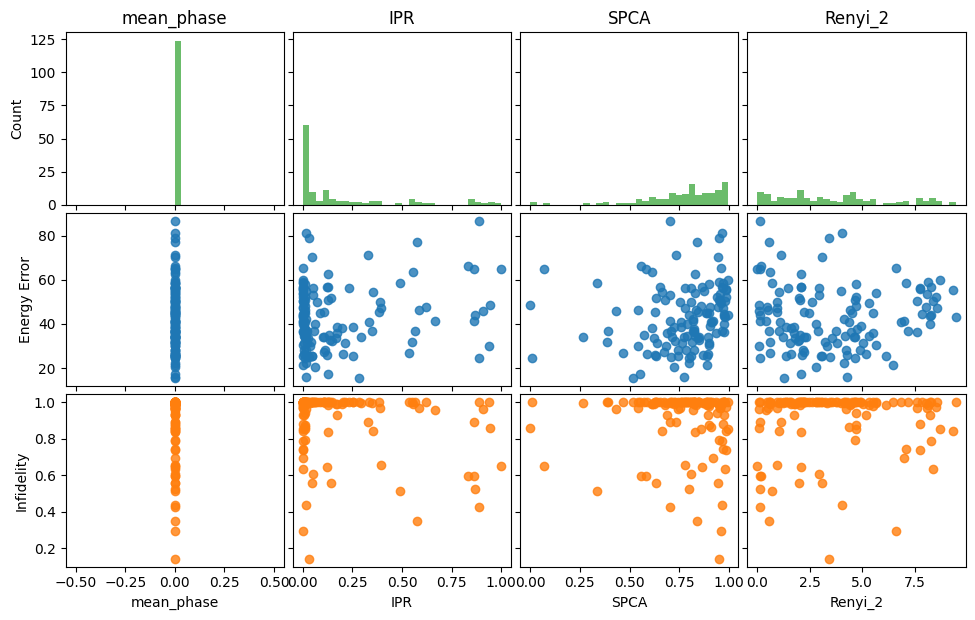

In [98]:
import matplotlib.pyplot as plt
N = len(hypothesis_names)
fig, axes = plt.subplots(3, N, figsize=(0.6*4*N, 0.6*10), sharey='row', sharex='col')

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram of hypothesis values
    axes[0, idx].hist(df[name], bins=30, color="C2", alpha=0.7)
    axes[0, idx].set_title(f"{name}")
    if idx == 0:
        axes[0, 0].set_ylabel("Count")

    # Second row: Energy error vs hypothesis
    axes[1, idx].scatter(df[name], df["Delta_E"].apply(lambda x: x[0]), color="C0", alpha=0.8)
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")

    # Third row: Infidelity vs hypothesis
    infid = df.apply(lambda row: infidelity(row["psi"], row["psi_0"]), axis=1)
    axes[2, idx].scatter(df[name], infid, color="C1", alpha=0.8)
    axes[2, idx].set_xlabel(name)
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")

plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


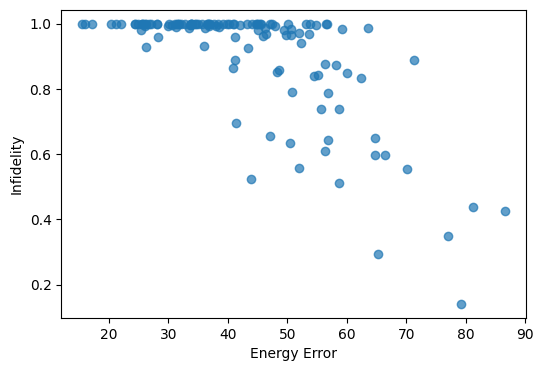

In [99]:
plt.figure(figsize=(6, 4))
plt.scatter(df["Delta_E"].apply(lambda x: x[0]), infid, alpha=0.7)
plt.xlabel("Energy Error")
plt.ylabel("Infidelity")
plt.show()